In [1]:
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
import nlp

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.seq2seq_generator import Seq2Seq, Encoder, Decoder
from src.cnn_discriminator import CNNDiscriminator
from src.rollout import ROLLOUT
from src.utils import *
from src.dataset import Dataset, Padder

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

sns.set_style('whitegrid')

### 1. load data

In [2]:
dataset_name = 'news'

In [3]:
%%time

if dataset_name == 'cnn':
    train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
    val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
    test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")
    train_articles = [item['article'] for item in train_dataset]
    train_highlights = [item['highlights'] for item in train_dataset]
    val_articles = [item['article'] for item in val_dataset]
    val_highlights = [item['highlights'] for item in val_dataset]
elif dataset_name == 'news':
    news = pd.read_csv('data/news_summary.csv')
    news.headlines = [process_str(s) for s in news.headlines]
    news.text = [process_str(s) for s in news.text]
    X_train, X_test = train_test_split(news, test_size=0.3,
                                       random_state=42)
    train_articles = X_train.text.values
    train_highlights = X_train.headlines.values
    val_articles = X_test.text.values
    val_highlights = X_test.headlines.values

CPU times: user 736 ms, sys: 32.2 ms, total: 768 ms
Wall time: 768 ms


### 2. sentencepiece model

In [4]:
train_new_model = False

In [5]:
%%time
if train_new_model:
    with open('data/news_texts.txt', 'a') as f:
        for article in tqdm(train_articles):
            f.write(article + '\n')
        for highlight in tqdm(train_highlights):
            f.write(highlight + '\n')
        for article in tqdm(val_articles):
            f.write(article + '\n')
        for highlight in tqdm(val_highlights):
            f.write(highlight + '\n')
            
    spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                                   model_prefix='news10k',
                                   vocab_size=10000,
                                   pad_id=0,
                                   bos_id=1,
                                   eos_id=2,
                                   unk_id=3)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


### 3. dataset and dataloaders

In [6]:
vocab_size = 10000
sp_modelname = f'sentencepiece_models/news{int(vocab_size/1000)}k.model'

In [7]:
sp = spm.SentencePieceProcessor(model_file=sp_modelname)

In [8]:
train_dataset = Dataset(train_articles, train_highlights, sp=sp)
val_dataset = Dataset(val_articles, val_highlights, sp=sp)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [9]:
for batch in train_dataloader:
    print(batch[0].size())
    print(batch[1].size())
    break

torch.Size([99, 128])
torch.Size([20, 128])


### 4. model architecture

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [11]:
writer = SummaryWriter()

In [12]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)

In [13]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=200,
                     padding_idx=padding_idx).to(device)

### 5. generator pretraining

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
lr = 1e-3
opt = torch.optim.Adam(G.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5)
start_teacher_forcing = 0.5
teacher_forcing_decay = 0.025
n_epochs = 50

epoch_losses = []
val_losses = []
iter_num = -1

In [16]:
for epoch_idx in range(n_epochs):
    G.train()
    total_loss = 0.
    teacher_forcing = start_teacher_forcing - epoch_idx*teacher_forcing_decay
    for batch_idx, data_input in tqdm(enumerate(train_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        opt.zero_grad()
        out = G(article, highlight, teacher_forcing_ratio=teacher_forcing)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1)
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset))
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    val_loss = total_loss / len(val_dataset)
    val_losses.append(val_loss)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    
    scheduler.step(val_loss)
    print(f'current lr {get_lr(opt)}')
    print(f'current teacher forcing: {teacher_forcing}')
    
    indices = sps.randint(0, out.size(1)).rvs(size=5)
    pred_texts = tensor_to_text(out[:, indices, :], sp, beam_search=True)
    truth_texts = tensor_to_text(highlight[:, indices], sp)
    for pred, truth in zip(pred_texts, truth_texts):
        print(f'predicted: {pred}')
        print(f'truth: {truth}\n')

20it [00:03,  6.21it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('generator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# save_path = 'saved_models/pretrained_seq2seq_gen_3.pth'
# torch.save(G.state_dict(), save_path)

### 6. discriminator pretraining

In [14]:
save_path = 'saved_models/pretrained_seq2seq_gen_3.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [15]:
G.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [16]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=3,
                     padding_idx=padding_idx).to(device)

In [18]:
criterion = nn.BCELoss()
lr = 1e-4
opt = torch.optim.Adam(D.parameters(), lr=lr)
n_epochs = 2

epoch_losses = []
val_losses = []
iter_num = -1
writer = SummaryWriter()

In [19]:
for epoch_idx in range(n_epochs):
    D.train()
    total_loss = 0.
    
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        opt.zero_grad()
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    D.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        total_loss += loss.data.item() * article.size(1) * 2

    val_losses.append(total_loss / len(val_dataset) / 2)
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')

539it [00:44, 12.18it/s]
2it [00:00, 14.04it/s]

epoch 0 train loss: 0.23779804286710338


231it [00:16, 14.16it/s]
2it [00:00, 11.64it/s]

epoch 0 val loss: 0.031208537723029284


539it [00:43, 12.32it/s]
2it [00:00, 13.94it/s]

epoch 1 train loss: 0.06076200075888883


231it [00:16, 14.15it/s]

epoch 1 val loss: 0.005752120049201727


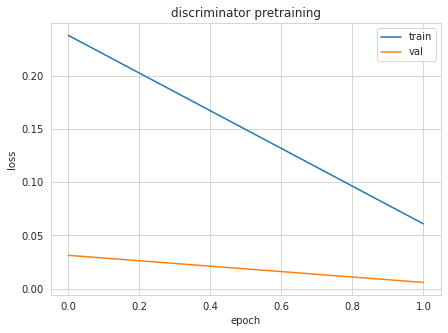

In [22]:
plt.figure(figsize=(7, 5))
plt.title('discriminator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
save_path = 'saved_models/pretrained_dis3.pth'
torch.save(D.state_dict(), save_path)

### 7. adversarial training

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [12]:
vocab_size = 10000
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/pretrained_seq2seq_gen_3.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [13]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=3,
                     padding_idx=padding_idx).to(device)
save_path = 'saved_models/pretrained_dis3.pth'
D.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [14]:
n_epochs = 60
rollout_num = 2
beta = 0.2
teacher_forcing = 0.6

In [15]:
writer = SummaryWriter()

In [16]:
G.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [17]:
D.train()

CNNDiscriminator(
  (embed): Embedding(10000, 256, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 256), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 256), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(3, 256), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=9, out_features=1, bias=True)
)

In [18]:
discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4)
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion_ml = nn.CrossEntropyLoss(ignore_index=0)
dis_criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, 'min', patience=5)

G_losses = []
D_losses = []
iter_num = -1
G_ce_val_losses = []

for epoch_idx in range(n_epochs):
    total_G_loss = 0.
    total_D_loss = 0.
    G.train()
    D.train()
    beta += 0.02 * epoch_idx
    beta = min(0.95, beta)
    teacher_forcing -= 0.02 * epoch_idx
    teacher_forcing = max(0, teacher_forcing)
    writer.add_scalar('Params/teacher_forcing', teacher_forcing, iter_num)
    writer.add_scalar('Params/beta', beta, iter_num)
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        
        # Discriminator
        gen_out, generated_highlight = G.sample(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = generated_highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight.permute(1, 0)], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(1)).to(device)
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        out = D(batch)
        loss = dis_criterion(out.squeeze(1), targets.float())
        loss.backward()
        discriminator_optimizer.step()
        total_D_loss += loss.data.item() * highlight.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/dis_adv_train', loss.data.item(), iter_num)
        
        # Generator
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        gen_out, generated_highlight = G.sample(article, highlight, teacher_forcing_ratio=teacher_forcing)
        generated_highlight = generated_highlight.permute(1, 0)  # (batch_size, seq_len)
        rollout_func = ROLLOUT(G)
        rewards = rollout_func.get_reward(article, generated_highlight, rollout_num, D)
        writer.add_scalar('Reward/train', rewards.mean().data.item(), iter_num)
        rewards = 1 - rewards
        pg_loss = G.batch_pgloss_generated(gen_out, generated_highlight, rewards)
        
        out = G(article, highlight, teacher_forcing_ratio=teacher_forcing)
        ml_loss = criterion_ml(out.permute(1, 2, 0), highlight.permute(1, 0))
        
        loss = beta*pg_loss + (1-beta)*ml_loss
        loss.backward()
        generator_optimizer.step()
        writer.add_scalar('Loss_train/loss', loss.data.item(), iter_num)
        writer.add_scalar('Loss_train/ml_loss', ml_loss.data.item(), iter_num)
        writer.add_scalar('Loss_train/pg_loss', pg_loss.data.item(), iter_num)
        total_G_loss += loss.data.item() * article.size(1)

    G_losses.append(total_G_loss / len(train_dataset))
    D_losses.append(total_D_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    print(f'epoch {epoch_idx} D loss: {D_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    total_reward = 0.
    total_ml_loss = 0.
    total_pg_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        gen_out, generated_highlight = G.sample(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = generated_highlight.permute(1, 0)  # (batch_size, seq_len)
        rollout_func = ROLLOUT(G)
        rewards = rollout_func.get_reward(article, generated_highlight, rollout_num, D)
        total_reward += rewards.mean().data.item() * article.size(1)
        rewards = 1 - rewards
        pg_loss = G.batch_pgloss_generated(gen_out, generated_highlight, rewards)
        
        out = G(article, highlight, teacher_forcing_ratio=0.)
        ml_loss = criterion_ml(out.permute(1, 2, 0), highlight.permute(1, 0))
        
        loss = beta*pg_loss + (1-beta)*ml_loss
        total_loss += loss.data.item() * article.size(1)
        
        total_ml_loss += ml_loss.data.item() * article.size(1)
        total_pg_loss += pg_loss.data.item() * article.size(1)
    writer.add_scalar('Reward/val', total_reward / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/loss', total_loss / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/ml_loss', total_ml_loss / len(val_dataset), iter_num)
    writer.add_scalar('Loss_val/pg_loss', total_pg_loss / len(val_dataset), iter_num)
    
    scheduler.step(total_loss)
    
    G_ce_val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {G_ce_val_losses[-1]}')
    # writer.add_scalar('Loss/gen_ce_val', G_ce_val_losses[-1], iter_num)
    
    
    indices = sps.randint(0, out.size(1)).rvs(size=10)
    pred_texts = tensor_to_text(out[:, indices, :], sp, beam_search=True)
    truth_texts = tensor_to_text(highlight[:, indices], sp)
    for pred, truth in zip(pred_texts, truth_texts):
        writer.add_text('Texts/pred', pred, iter_num)
        writer.add_text('Texts/truth', truth, iter_num)
        print(f'predicted: {pred}')
        print(f'truth: {truth}\n')

539it [15:49,  1.76s/it]
0it [00:00, ?it/s]

epoch 0 G loss: 2.605969012600481
epoch 0 D loss: 0.5976863747412873


231it [04:39,  1.21s/it]


epoch 0 val loss: 4.832602296925945


0it [00:00, ?it/s]

predicted: was toed to changed birth to schools rape victims
truth: was threatened to change asaram rape victim s age principal

predicted: whatsapp should have a difference in india union minister ceo
truth: whatsapp must have grievance officer in india it min to ceo

predicted: delhi metro moves sc to 60 60 crore to reliance
truth: delhi metro moves sc against 60 crore payment to rinfra arm

predicted: social media mediasenencsss trump trump
truth: social media giants are silencing millions of people trump

predicted: social media mediasenencsss trump trump
truth: social media giants are silencing millions of people trump

predicted: isi ak ak to be ashamed from trophy s
truth: akmal should be ashamed for being sent back to pak waqar

predicted: pm pm pm pm pm sssnanana s resigns
truth: georgia pm kvirikashvili resigns amid rift with ruling party

predicted: pm modi to visit china in first week of summit summit
truth: pm modi to attend brics summit in china

predicted: 355 men marri 

539it [15:57,  1.78s/it]
0it [00:00, ?it/s]

epoch 1 G loss: 2.518196712996763
epoch 1 D loss: 0.513051236769602


231it [04:40,  1.22s/it]


epoch 1 val loss: 4.740161946826073


0it [00:00, ?it/s]

predicted: 4 missiles fired from afghanistan in pakistan
truth: 4 missiles fired into pakistan from afghanistan

predicted: big b aishwarya aishwaryas documents of   panama papers
truth: amitabh aishwarya submit documents in panama papers probe

predicted: india smelling blood but we would be under great pressure coach
truth: india are smelling blood we will show them great respect langer

predicted: man creates robot that in in cars water of the engine
truth: man turns his car into a drivable hot tub

predicted: whatsapp should have a new news union minister ceo
truth: whatsapp must have grievance officer in india it min to ceo

predicted: was to change birth to birth in schools school rapes rape
truth: was threatened to change asaram rape victim s age principal

predicted: iit roorkee tests floating electricity from water water
truth: iit roorkee tests device to generate electricity from river flow

predicted: north korea coulded engines for for test tests study
truth: n korea missil

539it [15:58,  1.78s/it]
0it [00:00, ?it/s]

epoch 2 G loss: 2.443887748230902
epoch 2 D loss: 0.5066792928383326


231it [04:41,  1.22s/it]


epoch 2 val loss: 4.573483243842568


0it [00:00, ?it/s]

predicted: airbus probe probe into corruption charges over 146 cr fraud
truth: airbus launches internal corruption investigation

predicted: sc issues notice for rahul gandhi foringing for foring
truth: rahul given notice over nude dalit kids being beaten up video

predicted: ddkock rules out of ipl match of ipl match to injury
truth: delhi s last year top scorer quinton de kock out of ipl 2017

predicted: society has pm modi pm for welfare chief rss chief
truth: modi is a contractor of social welfare rss chief bhagwat

predicted: i would like work with any action with dutt dutt dutt rajkumar dutt
truth: would like to work with ranbir kapoor again rajkumar hirani

predicted: first look poster of sushant kriti starrer raabta unveiled
truth: first look poster of sushant kriti s raabta unveiled

predicted: amazon to test one hour for items in fashion show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: 20 killed in j k after eid attacks in j k
truth: 20 y

539it [15:56,  1.78s/it]
0it [00:00, ?it/s]

epoch 3 G loss: 2.3782261119625434
epoch 3 D loss: 0.506032413528079


231it [04:44,  1.23s/it]


epoch 3 val loss: 4.289505266407504


0it [00:00, ?it/s]

predicted: un evidence of human rights abuses al of syria
truth: enough evidence to convict syrian prez of war crimes un

predicted: rhea s sister  sister s 1st at cannes film fest fest
truth: sonam wears custom made jewellery by sister rhea at cannes

predicted: barcelona 1st club club to earn over over 126s in
truth: barcelona become world s 1st team to spend 500 million on wages

predicted: kartarpur corridor calls kartarpur for for mistake pm modi
truth: kartarpur corridor atonement for mistake made in 1947 pm modi

predicted: mccullum s test to fastest fastest in his last last match
truth: brendon mccullum hit test cricket s fastest ton in his last match

predicted: gotaradhya for the from my my actor on on 13 years
truth: received best compliment from dilip kumar for black big b

predicted: india smelling blood buty would be under great pressure coach
truth: india are smelling blood we will show them great respect langer

predicted: us man awarded 4 8 8 after eating corpse fossil

539it [15:56,  1.77s/it]
0it [00:00, ?it/s]

epoch 4 G loss: 2.289727535314261
epoch 4 D loss: 0.513671950942271


231it [04:44,  1.23s/it]


epoch 4 val loss: 3.9579189585531345


0it [00:00, ?it/s]

predicted: amazon to test 1 hr for items in fashion show show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: bars to be take against soldiers on militants army
truth: soldiers to face action for disrespecting militants bodies

predicted: model models dead dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: aus australia is good good good good good good aus coach
truth: sledging is a fun part of the game aus coach justin langer

predicted: 4 missiles fired from afghanistan in pakistan
truth: 4 missiles fired into pakistan from afghanistan

predicted: barcelona 1st club to world record over over 126ss
truth: barcelona become world s 1st team to spend 500 million on wages

predicted: society has pm modi pm for welfare chief rss chief
truth: modi is a contractor of social welfare rss chief bhagwat

predicted: french singeras dies after collapsing in concert
truth: french singer barbara weldens dies on stage d

539it [15:57,  1.78s/it]
0it [00:00, ?it/s]

epoch 5 G loss: 2.190731929375873
epoch 5 D loss: 0.5154967768543965


231it [04:44,  1.23s/it]


epoch 5 val loss: 3.511560177052757


0it [00:00, ?it/s]

predicted: ddkock rules out of ipl ipl match of ipl match
truth: delhi s last year top scorer quinton de kock out of ipl 2017

predicted: doctors put inmrityityss toss in telangana
truth: docs chant mantra for hours to bring down deaths in hospital

predicted: he am death penaltyeacheacheacheachss owaisi owaisi
truth: threat to my life claims aimim leader akbaruddin owaisi

predicted: 20 killed in j k after eid attacks in j k
truth: 20 yr old killed in clashes after eid prayers in kashmir

predicted: facebook asks equi to share info info info info info
truth: facebook asks us banks for users financial data report

predicted: srikanthambis padma shri india s highestst asiali
truth: kidambi srikanth conferred with padma shri award

predicted: airbus probe probe probe corruption charges oversexexexs
truth: airbus launches internal corruption investigation

predicted: aus australia is good good good good good good aus coach
truth: sledging is a fun part of the game aus coach justin langer


539it [15:54,  1.77s/it]
0it [00:00, ?it/s]

epoch 6 G loss: 2.0692515438580483
epoch 6 D loss: 0.5126686879012919


231it [04:44,  1.23s/it]


epoch 6 val loss: 3.0410978867107077


0it [00:00, ?it/s]

predicted: sehwag moreinging sehwag oninginging pad pad
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss

predicted: farmer farmers makinging dumpingssss strike strike strike
truth: farmers dump vegetables spill milk on roads during protest

predicted: doctors doctorss inmityityrssss
truth: docs chant mantra for hours to bring down deaths in hospital

predicted: thievesess screen under inside house housen in
truth: us thieves try to steal tv return it as it didn t fit in car

predicted: barable to be against soldiers armyss army army
truth: soldiers to face action for disrespecting militants bodies

predicted: pm modi to visit china in first week summits summit
truth: pm modi to attend brics summit in china

predicted: thievesess screen under inside house housen in
truth: us thieves try to steal tv return it as it didn t fit in car

predicted: french singerass dies after duringing concert
truth: french singer barbara weldens dies on stage during concert

predicte

539it [15:49,  1.76s/it]
0it [00:00, ?it/s]

epoch 7 G loss: 1.9108256471281684
epoch 7 D loss: 0.4493603262613321


231it [04:44,  1.23s/it]


epoch 7 val loss: 2.4714261342635915


0it [00:00, ?it/s]

predicted: used toanansssss on s s rashid
truth: csk pacer lungi reveals he used to sell peanuts on roadside

predicted: farmer farmers makinginging dumpssss strike strike strike
truth: farmers dump vegetables spill milk on roads during protest

predicted: kerala govtingsssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: man dies after rid dies dies dies in s car into car
truth: man dies after crashing his scooter into zareen khan s car in goa

predicted: world s mostedededs neuros
truth: how does the world s smallest computer work

predicted: world s mostedededs neuros
truth: how does the world s smallest computer work

predicted: india smell noting blood buty would be under great coach coach
truth: india are smelling blood we will show them great respect langer

predicted: social media mediasenenenss trump trumps
truth: social media giants are silencing millions of people trump

predicted: us man awarded 4 4 for afteringing fossil fossil fo

539it [15:51,  1.77s/it]
0it [00:00, ?it/s]

epoch 8 G loss: 1.666291037724547
epoch 8 D loss: 0.3808399245298698


231it [04:43,  1.23s/it]


epoch 8 val loss: 1.8990632335464748


0it [00:00, ?it/s]

predicted: srikanthambis padma shri shri india s highest asia
truth: kidambi srikanth conferred with padma shri award

predicted: nurse whosed foringing woman to baby to to
truth: italian nurse jailed for calming newborn with morphine

predicted: man dies after rid dies dies dies in s car s car
truth: man dies after crashing his scooter into zareen khan s car in goa

predicted: wheelchair bound passengersed flight flight flight flight flight passengers
truth: air india refuses to let wheelchair bound passenger on plane

predicted: un evidenceed evidence rights rightss of of
truth: enough evidence to convict syrian prez of war crimes un

predicted: 18 cpi mss life life lifeed  tmc tmc
truth: 18 cpi m men get life term for killing tmc workers in 2010

predicted: big b aishwarya bs documents documents with  paper
truth: amitabh aishwarya submit documents in panama papers probe

predicted: 14 yr old killss watch watch watch video videoed in
truth: scolded for using phone mumbai teen hangs 

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 9 G loss: 1.6128117696471884
epoch 9 D loss: 0.2750131170370299


231it [04:44,  1.23s/it]


epoch 9 val loss: 1.7719717218657747


0it [00:00, ?it/s]

predicted: wheelchair passengerseded flight flight flight flight flight passenger flight
truth: air india refuses to let wheelchair bound passenger on plane

predicted: zoomcar raises 40 million from mahindra mahind startup others
truth: car rental startup zoomcar raises 40 million in series c

predicted: 18 cpi msed life life lifeed  tmc tmc
truth: 18 cpi m men get life term for killing tmc workers in 2010

predicted: man buildssable  in in water water of the
truth: man turns his car into a drivable hot tub

predicted: 14 yr old killssing watch watch video videoing video
truth: scolded for using phone mumbai teen hangs self dies in hospital

predicted: zos got women at at at foree gnnve
truth: game of thrones puts women at the forefront gwendoline

predicted: gotara award for for  from aurilip on on 13 years
truth: received best compliment from dilip kumar for black big b

predicted: isi ak ak ashamhameded      
truth: akmal should be ashamed for being sent back to pak waqar

predicte

539it [15:52,  1.77s/it]
0it [00:00, ?it/s]

epoch 10 G loss: 1.586977348427324
epoch 10 D loss: 0.22131294235673654


231it [04:44,  1.23s/it]


epoch 10 val loss: 1.7059225912707263


0it [00:00, ?it/s]

predicted: my child senenclaimssss s abd abd de
truth: de villiers hid love letters he wrote in his house s roof

predicted: google us us its power that ai ai chip chip chip chip
truth: google using ai to improve battery life on android phones

predicted: srikanthambis padma shri shri india s highest
truth: kidambi srikanth conferred with padma shri award

predicted: amazon to test 1 hr for for itemss show show show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: daughter daughter should should t  good good touch touch touch mp cm
truth: daughters should be taught about good bad touch mp cm

predicted: pak ak ak as ashameded     s
truth: akmal should be ashamed for being sent back to pak waqar

predicted: uae deports 36 yr old over over over links links isi isi
truth: uae deports indian over suspected links with isis

predicted: un evidences rights rights rights rights of al
truth: enough evidence to convict syrian prez of war crimes un

predicted: bar

539it [15:51,  1.77s/it]
0it [00:00, ?it/s]

epoch 11 G loss: 1.6203682917197268
epoch 11 D loss: 0.1995774938738997


231it [04:43,  1.23s/it]


epoch 11 val loss: 1.7703791155263842


0it [00:00, ?it/s]

predicted: 23 billionaire billionairess   sts
truth: 27 hurun rich list billionaires passed away last year

predicted: aus australiaing is good good good good good australialangerlangerlangerlanger
truth: sledging is a fun part of the game aus coach justin langer

predicted: kerala govtingssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: first look poster of sushantshant starrer raabta unveil
truth: first look poster of sushant kriti s raabta unveiled

predicted: amazon to test 1 hr for for itemsnn fashion show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: bars to be against soldiersst armys army army army army
truth: soldiers to face action for disrespecting militants bodies

predicted: 14 year old killss watch watch watch video videoing
truth: scolded for using phone mumbai teen hangs self dies in hospital

predicted: kock rules out ipl ipl ipl 10 ipl ipl
truth: delhi s last year top scorer quinton de ko

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 12 G loss: 1.6040080182643717
epoch 12 D loss: 0.173853911014661


231it [04:42,  1.22s/it]


epoch 12 val loss: 1.714317682090561


0it [00:00, ?it/s]

predicted: pitcha teamseded bengaluruu bengaluruu
truth: match s pre lunch session extended as food stuck in b luru traffic

predicted: 20 killed in j k after eidss in in in
truth: 20 yr old killed in clashes after eid prayers in kashmir

predicted: india is noting bloody would be under under to coach coach
truth: india are smelling blood we will show them great respect langer

predicted: keralaingingsssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: death kills in dead by ins in in
truth: gorkhaland supporter killed in police firing in darjeeling

predicted: pitcha teamseded bengaluruu bengaluruu
truth: match s pre lunch session extended as food stuck in b luru traffic

predicted: un evidences rights rights rightsss of
truth: enough evidence to convict syrian prez of war crimes un

predicted: delhi metro moves sc to 60 60 60 to to reliance
truth: delhi metro moves sc against 60 crore payment to rinfra arm

predicted: mel characterss at at a

539it [15:51,  1.77s/it]
0it [00:00, ?it/s]

epoch 13 G loss: 1.625386834006138
epoch 13 D loss: 0.1671757952849901


231it [04:42,  1.22s/it]


epoch 13 val loss: 1.69902852205382


0it [00:00, ?it/s]

predicted: i taka for foringing conductor conductor conductor conductor bus driver
truth: suffering for no fault driver who let langur control steering

predicted: north korea coulded engines for test testss study
truth: n korea missiles used russian or ukrainian engines reports

predicted: demonetising was parliamentededededed minister law minister
truth: manmohan s speech on demonetisation was scripted prasad

predicted: 18 cpi msss life lifeed  3 tmc
truth: 18 cpi m men get life term for killing tmc workers in 2010

predicted: nasa probesssss lakh lakhss ons
truth: nasa spacecraft landed on mars with names of over 1l indians

predicted: 23 billionaire billionairess  stst s
truth: 27 hurun rich list billionaires passed away last year

predicted: model models dead dead dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: barable to be take againstst armysss armys
truth: soldiers to face action for disrespecting militants bodies

predicted:

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 14 G loss: 1.61573601732686
epoch 14 D loss: 0.15953078939385806


231it [04:43,  1.23s/it]


epoch 14 val loss: 1.708591141693799


0it [00:00, ?it/s]

predicted: airbus probe probe probe corruptiononssexexexex
truth: airbus launches internal corruption investigation

predicted: solar solar is to to earth earth earth
truth: minor solar flare expected to hit earth today cause auroras

predicted: airbus probe probe probe corruptiononssexexexex
truth: airbus launches internal corruption investigation

predicted: india is noting blood to will be under to coach coach
truth: india are smelling blood we will show them great respect langer

predicted: airbus probe probe probe corruptiononssexexexex
truth: airbus launches internal corruption investigation

predicted: nasas proposess co comicmicmicmicing
truth: nasa team proposes using sun as cosmic magnifying glass

predicted: got original award for for   my his d d on
truth: received best compliment from dilip kumar for black big b

predicted: union union minister minister minister swor swor in in bihar governor
truth: satya pal malik sworn in as governor of bihar

predicted: us gets 4 4 for 

539it [15:56,  1.77s/it]
0it [00:00, ?it/s]

epoch 15 G loss: 1.6597251505801902
epoch 15 D loss: 0.1734506294148586


231it [04:43,  1.23s/it]


epoch 15 val loss: 1.7555193832414


0it [00:00, ?it/s]

predicted: model models dead dead dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: kejriwal kejriwal kejriwal defamationion case overststst police
truth: delhi cm discharged in defamation case over thulla remark

predicted: ferrari mercede driver driver car car car car car pr pr car car car
truth: f1 driver crashes after race ends rides back on another car

predicted: never think about what i have have done hardinging kajol kajol
truth: i never think about what i should ve done differently kajol

predicted: thiev thievesss transparent inside house housen in
truth: us thieves try to steal tv return it as it didn t fit in car

predicted: ddkock rules out ipl ipl ipl of ipl 10
truth: delhi s last year top scorer quinton de kock out of ipl 2017

predicted: google using its power to ai ai ai chips chips
truth: google using ai to improve battery life on android phones

predicted: societies has pm modi for for welfare chief rss chief
truth: mo

539it [15:54,  1.77s/it]
0it [00:00, ?it/s]

epoch 16 G loss: 1.6468785033408773
epoch 16 D loss: 0.16049542070888892


231it [04:43,  1.23s/it]


epoch 16 val loss: 1.7169791327627333


0it [00:00, ?it/s]

predicted: my  was 16enclaimsss s s abd abd de 
truth: de villiers hid love letters he wrote in his house s roof

predicted: 23 billionaire billionaire ss   ss
truth: 27 hurun rich list billionaires passed away last year

predicted: india smelling blood bloody would be be under to coach coach
truth: india are smelling blood we will show them great respect langer

predicted: cong congress joins for for for for for poll
truth: cong ncp join hands against bjp for maha council by poll

predicted: world s smallest computer stretchedsss
truth: how does the world s smallest computer work

predicted: model model model shot dead dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: wased to to to birth in school schools rape rape rape
truth: was threatened to change asaram rape victim s age principal

predicted: sachin attend attend b day s b m m m ambani
truth: sachin tendulkar attends krunal pandya s wedding in mumbai

predicted: i think about what

539it [15:54,  1.77s/it]
0it [00:00, ?it/s]

epoch 17 G loss: 1.5807764060821268
epoch 17 D loss: 0.10581957550414348


231it [04:45,  1.23s/it]


epoch 17 val loss: 1.6620209788061457


0it [00:00, ?it/s]

predicted: sehwag moreinging sehwag seh sehwag onss winsss
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss

predicted: am b aishwarya bs documents documents with paper paper
truth: amitabh aishwarya submit documents in panama papers probe

predicted: amazon to test 1 hr for forss show show show show london
truth: amazon to test one hour delivery for fashion show clothes

predicted: my child wasenenclaimsss s abd abd abd de de
truth: de villiers hid love letters he wrote in his house s roof

predicted: i taka for for amma conductor conductor conductor conductor driver driver driver
truth: suffering for no fault driver who let langur control steering

predicted: i taka for for amma conductor conductor conductor conductor driver driver driver
truth: suffering for no fault driver who let langur control steering

predicted: social media mediasenensss trump trumps trump
truth: social media giants are silencing millions of people trump

predicted: srikanth sed padma sh

539it [15:52,  1.77s/it]
0it [00:00, ?it/s]

epoch 18 G loss: 1.575540501675401
epoch 18 D loss: 0.10235732492842602


231it [04:44,  1.23s/it]


epoch 18 val loss: 1.6899158368124063


0it [00:00, ?it/s]

predicted: north korea could crack engines for for test test study study
truth: n korea missiles used russian or ukrainian engines reports

predicted: i think think about i have have have in in film kajol kajol
truth: i never think about what i should ve done differently kajol

predicted: sachin tend attendss kl and b b m ambani
truth: sachin tendulkar attends krunal pandya s wedding in mumbai

predicted: srikanth sed padma shri shri india s highest 53
truth: kidambi srikanth conferred with padma shri award

predicted: society has pm modi pm for wel welfare chief rss chief
truth: modi is a contractor of social welfare rss chief bhagwat

predicted: aus australia is is good good good good good auslanger
truth: sledging is a fun part of the game aus coach justin langer

predicted: un evidences evidence rights rights rightsss
truth: enough evidence to convict syrian prez of war crimes un

predicted: astronomers helped waveseded yearss
truth: online volunteers help find star that exploded 9

539it [15:46,  1.76s/it]
0it [00:00, ?it/s]

epoch 19 G loss: 1.588713440039432
epoch 19 D loss: 0.09357299670386675


231it [04:44,  1.23s/it]


epoch 19 val loss: 1.711888846050477


0it [00:00, ?it/s]

predicted: un evidences evidence rights rights rightsss
truth: enough evidence to convict syrian prez of war crimes un

predicted: zoomcar raises 40 mn infrom mahindra startups
truth: car rental startup zoomcar raises 40 million in series c

predicted: b luru policesss challenge onoutoutout
truth: b luru police ask people to wear helmets share 10 secs challenge

predicted: cbi witch evidence with hunting kasau s saarushi
truth: cbi planted witnesses in aarushi murder case allahabad hc

predicted: my senclaimclaimsss s s abd abd abd de villiers
truth: de villiers hid love letters he wrote in his house s roof

predicted: us maned 4 4 4 afteringing fossil fossil fossil
truth: us man awarded 4 8 crore after beer burns his organs

predicted: amazon should pay real moneys taxesss donald trump
truth: amazon must pay real costs and taxes now donald trump

predicted: barable to be against soldiers armysss army armys
truth: soldiers to face action for disrespecting militants bodies

predicted: y

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 20 G loss: 1.6308116108421389
epoch 20 D loss: 0.10319310197916041


231it [04:44,  1.23s/it]


epoch 20 val loss: 1.7565417275681234


0it [00:00, ?it/s]

predicted: astronomers helped wavesed earthsss
truth: online volunteers help find star that exploded 97 cr yrs ago

predicted: 4 missile fires from naval base in in
truth: 4 missiles fired into pakistan from afghanistan

predicted: would would like work with any any actor dutt dutt dutt dutt
truth: would like to work with ranbir kapoor again rajkumar hirani

predicted: iitians testing floating electricit plant from water water
truth: iit roorkee tests device to generate electricity from river flow

predicted: airline passengers passengers to flight air flight flight passenger
truth: air india refuses to let wheelchair bound passenger on plane

predicted: nasa propose proposes planeting comicmicmicmic
truth: nasa team proposes using sun as cosmic magnifying glass

predicted: kartarpur corridor calls on for for for pm modi modi
truth: kartarpur corridor atonement for mistake made in 1947 pm modi

predicted: barcelo becomes 1st club to earn over 126sss
truth: barcelona become world s 1st 

539it [15:52,  1.77s/it]
0it [00:00, ?it/s]

epoch 21 G loss: 1.6446171113976757
epoch 21 D loss: 0.08760514423060776


231it [04:44,  1.23s/it]


epoch 21 val loss: 1.7053393879571883


0it [00:00, ?it/s]

predicted: gotara award for for   my my dilip on 13 years
truth: received best compliment from dilip kumar for black big b

predicted: i never should have done ve have ve ve in in in film kajol
truth: i never think about what i should ve done differently kajol

predicted: google using deepmind ai ai ai ai device
truth: google using ai to improve battery life on android phones

predicted: 20 killed in j k aftersss in in in
truth: 20 yr old killed in clashes after eid prayers in kashmir

predicted: i never should have done ve have ve ve in in in film kajol
truth: i never think about what i should ve done differently kajol

predicted: goa man dies after dies s dies in bike into into into brother
truth: man dies after crashing his scooter into zareen khan s car in goa

predicted: woman womans with after after lit litering
truth: us woman severely injured after mistaking dynamite for candle

predicted: nation will become asian pure another imran imran khan akhtarakhtarakhtar
truth: pak will

539it [15:49,  1.76s/it]
0it [00:00, ?it/s]

epoch 22 G loss: 1.594165507758536
epoch 22 D loss: 0.06019230956572966


231it [04:43,  1.23s/it]


epoch 22 val loss: 1.6692236268517529


0it [00:00, ?it/s]

predicted: sehwag slams more sehinginging seh pad pad pad
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss

predicted: congress congressss for for for for for poll
truth: cong ncp join hands against bjp for maha council by poll

predicted: amazon should pay real moneysssss donald trump
truth: amazon must pay real costs and taxes now donald trump

predicted: australian australia is is good good good good good australialanger
truth: sledging is a fun part of the game aus coach justin langer

predicted: delhi metro moves orders to 60 60 to to relian
truth: delhi metro moves sc against 60 crore payment to rinfra arm

predicted: govt issues notice notice rahul rahul rahul foringingings
truth: rahul given notice over nude dalit kids being beaten up video

predicted: daughters should t t good good good touch touch mp mp chouhan
truth: daughters should be taught about good bad touch mp cm

predicted: thousands can walk walk walk a on attack attack attack attack
truth: ev

539it [15:51,  1.76s/it]
0it [00:00, ?it/s]

epoch 23 G loss: 1.596021906728667
epoch 23 D loss: 0.05790741342908414


231it [04:44,  1.23s/it]


epoch 23 val loss: 1.681828925209088


0it [00:00, ?it/s]

predicted: we will become strong pure another imran imran khan akhtarakhtar
truth: pak will become asian tiger under imran khan shoaib akhtar

predicted: 23 billionaire billionairess   st 
truth: 27 hurun rich list billionaires passed away last year

predicted: cbi witch huntingingsss sarushia
truth: cbi planted witnesses in aarushi murder case allahabad hc

predicted: kartarpur corridor call called a for for mistake pm modi
truth: kartarpur corridor atonement for mistake made in 1947 pm modi

predicted: airline passengers flyers flight flight to flight flight flight flyer
truth: air india refuses to let wheelchair bound passenger on plane

predicted: farmer farmersinging dumpings fruitss strike strike strike
truth: farmers dump vegetables spill milk on roads during protest

predicted: gotara award for for   my actor d on on years
truth: received best compliment from dilip kumar for black big b

predicted: isi akmal to be as ased     pakni
truth: akmal should be ashamed for being sent 

539it [15:51,  1.77s/it]
0it [00:00, ?it/s]

epoch 24 G loss: 1.5931228035418414
epoch 24 D loss: 0.053881739656268926


231it [04:43,  1.23s/it]


epoch 24 val loss: 1.7004265510140668


0it [00:00, ?it/s]

predicted: kartarpur corridor call calleded for for mistake pm modi
truth: kartarpur corridor atonement for mistake made in 1947 pm modi

predicted: farmer farmersinging dumpings fruitss strike strike strike
truth: farmers dump vegetables spill milk on roads during protest

predicted: north korea could crack engines for for test tests study
truth: n korea missiles used russian or ukrainian engines reports

predicted: amazon to test 1 hr for for items show in show show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: d de des rule out of ipl ipl 10 ipl match
truth: delhi s last year top scorer quinton de kock out of ipl 2017

predicted: uae deports yr yr old  over over links links links
truth: uae deports indian over suspected links with isis

predicted: 18 cpi msss life lifeed  tmc tmc
truth: 18 cpi m men get life term for killing tmc workers in 2010

predicted: barcelo becomes 1st club to earn over ins in
truth: barcelona become world s 1st team to spe

539it [15:52,  1.77s/it]
0it [00:00, ?it/s]

epoch 25 G loss: 1.604218140877913
epoch 25 D loss: 0.047734775696205066


231it [04:43,  1.23s/it]


epoch 25 val loss: 1.7299870018358012


0it [00:00, ?it/s]

predicted: kerala panchayats makes freess for for marriages
truth: village issues marriage certificate only after green wedding

predicted: thievesess screen under inside house housenn in
truth: us thieves try to steal tv return it as it didn t fit in car

predicted: frenchasss dies duringing concert
truth: french singer barbara weldens dies on stage during concert

predicted: climb climbs 30 ft ft ft jump jump back back ex ex e
truth: man climbs 30 feet ghaziabad hoarding to win back ex fianc e

predicted: demonetismohan speechedededededed minister minister
truth: manmohan s speech on demonetisation was scripted prasad

predicted: barcelo becomes 1st club to earn over inss
truth: barcelona become world s 1st team to spend 500 million on wages

predicted: would would like work with any any actor dutt dutt dutt
truth: would like to work with ranbir kapoor again rajkumar hirani

predicted: sehwag moreinginging sehing pad pad pad seh seh
truth: aus ke score par laga gst bhaari pad gaya se

539it [15:49,  1.76s/it]
0it [00:00, ?it/s]

epoch 26 G loss: 1.6154099373590378
epoch 26 D loss: 0.04566998091568515


231it [04:44,  1.23s/it]


epoch 26 val loss: 1.719825552503315


0it [00:00, ?it/s]

predicted: why picturess walk walk walk on attack attack attack attack
truth: event guests sing you ll never walk alone over terror threat

predicted: nurse whosed foringingingmememese
truth: italian nurse jailed for calming newborn with morphine

predicted: amazon should pay real realss taxess donald trump
truth: amazon must pay real costs and taxes now donald trump

predicted: zoomcar raises 40 million from mahindra mahind startup other
truth: car rental startup zoomcar raises 40 million in series c

predicted: cbi witch huntingingsss saarushi
truth: cbi planted witnesses in aarushi murder case allahabad hc

predicted: uae deports yr yr old  over over links links links
truth: uae deports indian over suspected links with isis

predicted: astronomers helped wave wavess earth years
truth: online volunteers help find star that exploded 97 cr yrs ago

predicted: 14 year old killssing watch watch video videoing video
truth: scolded for using phone mumbai teen hangs self dies in hospital

p

539it [15:49,  1.76s/it]
0it [00:00, ?it/s]

epoch 27 G loss: 1.62682568187913
epoch 27 D loss: 0.041693902026070116


231it [04:43,  1.23s/it]


epoch 27 val loss: 1.7481345343180317


0it [00:00, ?it/s]

predicted: armyable to be againstst army army armyss armys
truth: soldiers to face action for disrespecting militants bodies

predicted: solar solar is to to earth earth earth
truth: minor solar flare expected to hit earth today cause auroras

predicted: armyable to be againstst army army armyss armys
truth: soldiers to face action for disrespecting militants bodies

predicted: would would work with any any with dutt dutt dutt dutt rajkumar
truth: would like to work with ranbir kapoor again rajkumar hirani

predicted: sehwag moreinginging sehing pad pad pad seh seh
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss

predicted: us man awarded 4 4 afteringing fossil fossil fossil fossil
truth: us man awarded 4 8 crore after beer burns his organs

predicted: un evidence of rights rights rightsss of
truth: enough evidence to convict syrian prez of war crimes un

predicted: google using using ai ai ai ai ai android
truth: google using ai to improve battery life on andro

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 28 G loss: 1.6350206742580207
epoch 28 D loss: 0.03653994369278386


231it [04:43,  1.23s/it]


epoch 28 val loss: 1.7458709060796485


0it [00:00, ?it/s]

predicted: facebook askss us to share info info info infos
truth: facebook asks us banks for users financial data report

predicted: 20 killed in j k after eidss in in in
truth: 20 yr old killed in clashes after eid prayers in kashmir

predicted: 20 killed in j k after eidss in in in
truth: 20 yr old killed in clashes after eid prayers in kashmir

predicted: facebook askss us to share info info info infos
truth: facebook asks us banks for users financial data report

predicted: sc issues notice notice rahul rahul rahul foringing dalits
truth: rahul given notice over nude dalit kids being beaten up video

predicted: indonesian model kills dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: d de des rule out of ipl ipl 10 ipl match
truth: delhi s last year top scorer quinton de kock out of ipl 2017

predicted: woman leaves off after after litingings in
truth: us woman severely injured after mistaking dynamite for candle

predicted: facebook 

539it [15:48,  1.76s/it]
0it [00:00, ?it/s]

epoch 29 G loss: 1.640132578629373
epoch 29 D loss: 0.03722306060259697


231it [04:43,  1.23s/it]


epoch 29 val loss: 1.7625346332985325


0it [00:00, ?it/s]

predicted: india smell smelling bloody would be be under to coach coach
truth: india are smelling blood we will show them great respect langer

predicted: india smell smelling bloody would be be under to coach coach
truth: india are smelling blood we will show them great respect langer

predicted: nasas proposess co comicmicmicmicing glass
truth: nasa team proposes using sun as cosmic magnifying glass

predicted: woman leaves off after afteringingss in
truth: us woman severely injured after mistaking dynamite for candle

predicted: north korea could crack engines for for test tests study
truth: n korea missiles used russian or ukrainian engines reports

predicted: cong congressss to for for for for poll
truth: cong ncp join hands against bjp for maha council by poll

predicted: doctorsss inmrityityrssss gana
truth: docs chant mantra for hours to bring down deaths in hospital

predicted: nasas proposess co comicmicmicmicing glass
truth: nasa team proposes using sun as cosmic magnifying 

539it [15:48,  1.76s/it]
0it [00:00, ?it/s]

epoch 30 G loss: 1.6451295560799133
epoch 30 D loss: 0.03225738590433934


231it [04:44,  1.23s/it]


epoch 30 val loss: 1.7573044860570162


0it [00:00, ?it/s]

predicted: zoomcar raises 40 million infrom mahindra mahind startup other
truth: car rental startup zoomcar raises 40 million in series c

predicted: mccullum scores test test s faste fastest in in last last last match
truth: brendon mccullum hit test cricket s fastest ton in his last match

predicted: clash inss women at at fore gtntdo
truth: game of thrones puts women at the forefront gwendoline

predicted: kartarpur corridor call calleded for for modi pm modi
truth: kartarpur corridor atonement for mistake made in 1947 pm modi

predicted: astronomers helped wave wavess yearss
truth: online volunteers help find star that exploded 97 cr yrs ago

predicted: indonesian model kills dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: demonetismohan speechedededededed minister minister
truth: manmohan s speech on demonetisation was scripted prasad

predicted: 4 missiles fire from naval base in in pakistan
truth: 4 missiles fired into pakistan 

539it [15:49,  1.76s/it]
0it [00:00, ?it/s]

epoch 31 G loss: 1.6561212500905602
epoch 31 D loss: 0.032073101854767395


231it [04:43,  1.23s/it]


epoch 31 val loss: 1.7678576728676656


0it [00:00, ?it/s]

predicted: pitch cricket venueeded to bengaluruuuuu
truth: match s pre lunch session extended as food stuck in b luru traffic

predicted: big b aishwarya bs document documents with  panama paper
truth: amitabh aishwarya submit documents in panama papers probe

predicted: sachin attend attend b day celebration b b ambani ambani
truth: sachin tendulkar attends krunal pandya s wedding in mumbai

predicted: google using using ai ai ai ai to chipsroid
truth: google using ai to improve battery life on android phones

predicted: solar solar is to to earth earth earth
truth: minor solar flare expected to hit earth today cause auroras

predicted: airline passengers flyers flight flight to flight flight flight
truth: air india refuses to let wheelchair bound passenger on plane

predicted: un evidence of rights rights rightss of attack
truth: enough evidence to convict syrian prez of war crimes un

predicted: frenchasss dies duringing concert
truth: french singer barbara weldens dies on stage dur

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 32 G loss: 1.6684077522065166
epoch 32 D loss: 0.029277795650125518


231it [04:43,  1.23s/it]


epoch 32 val loss: 1.7663757436050398


0it [00:00, ?it/s]

predicted: airbus probe probe probe corruption chargesssexexex
truth: airbus launches internal corruption investigation

predicted: zoomcar raises 40 million infrom mahindra mahind startup other
truth: car rental startup zoomcar raises 40 million in series c

predicted: demonetismohan speechedededededed minister minister
truth: manmohan s speech on demonetisation was scripted prasad

predicted: sonam ss  sister forst at cannes cannes cannes fest
truth: sonam wears custom made jewellery by sister rhea at cannes

predicted: thievesess screen under inside house housenn in
truth: us thieves try to steal tv return it as it didn t fit in car

predicted: daughters should t t good good good touch touch touch mp chouhan
truth: daughters should be taught about good bad touch mp cm

predicted: cannot run run by byss sports sports sports min
truth: sports can t be run by bureaucrats sports minister rathore

predicted: vajpayee first first to deliver speech in in  in the
truth: late pm vajpayee was

539it [15:46,  1.76s/it]
0it [00:00, ?it/s]

epoch 33 G loss: 1.67285591849882
epoch 33 D loss: 0.0304708551827485


231it [04:43,  1.23s/it]


epoch 33 val loss: 1.7945645170997448


0it [00:00, ?it/s]

predicted: nurse whosed foringingingmememese
truth: italian nurse jailed for calming newborn with morphine

predicted: clash inss women at at fore gtntdo
truth: game of thrones puts women at the forefront gwendoline

predicted: nation will become asian pure with imran imran khan akhtarakhtar
truth: pak will become asian tiger under imran khan shoaib akhtar

predicted: saed toanananssss on s rashid s rashid
truth: csk pacer lungi reveals he used to sell peanuts on roadside

predicted: cbi witch huntingingss s onaarushi
truth: cbi planted witnesses in aarushi murder case allahabad hc

predicted: barable to be againstst army armys army armys army
truth: soldiers to face action for disrespecting militants bodies

predicted: would would work with any any any dutt dutt dutt dutt
truth: would like to work with ranbir kapoor again rajkumar hirani

predicted: nation will become asian pure with imran imran khan akhtarakhtar
truth: pak will become asian tiger under imran khan shoaib akhtar

predi

539it [15:48,  1.76s/it]
0it [00:00, ?it/s]

epoch 34 G loss: 1.6776479480435484
epoch 34 D loss: 0.026406087174267442


231it [04:43,  1.23s/it]


epoch 34 val loss: 1.7895623978502095


0it [00:00, ?it/s]

predicted: woman leaves off after afteringingss in
truth: us woman severely injured after mistaking dynamite for candle

predicted: astronomers helped wave wavess yearss
truth: online volunteers help find star that exploded 97 cr yrs ago

predicted: indonesian model kills dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: b luru policesss challenge onoutoutout
truth: b luru police ask people to wear helmets share 10 secs challenge

predicted: cbi witch huntingingss s onaarushi
truth: cbi planted witnesses in aarushi murder case allahabad hc

predicted: union union minister minister swor sworn in governor bihar governor
truth: satya pal malik sworn in as governor of bihar

predicted: us man awarded 4 4 afteringing fossil fossil fossil fossil
truth: us man awarded 4 8 crore after beer burns his organs

predicted: kejriwal cm kejriwal defamat defamation case overstibib
truth: delhi cm discharged in defamation case over thulla remark

predict

539it [15:46,  1.76s/it]
0it [00:00, ?it/s]

epoch 35 G loss: 1.6780336466954284
epoch 35 D loss: 0.028668186179298418


231it [04:43,  1.23s/it]


epoch 35 val loss: 1.8112364628140445


0it [00:00, ?it/s]

predicted: google using using ai ai ai ai to chipsroid
truth: google using ai to improve battery life on android phones

predicted: my child senenclaimssss s abd abd
truth: de villiers hid love letters he wrote in his house s roof

predicted: un evidence of rights rights rightss of attack
truth: enough evidence to convict syrian prez of war crimes un

predicted: amazon should pay real realss taxess donald trump
truth: amazon must pay real costs and taxes now donald trump

predicted: solar solar is to to earth earth earth
truth: minor solar flare expected to hit earth today cause auroras

predicted: first look poster of sushantshant ser raabta unveiled
truth: first look poster of sushant kriti s raabta unveiled

predicted: world s smallest computer computersss
truth: how does the world s smallest computer work

predicted: barcelona 1st 1 club to earn over over ins
truth: barcelona become world s 1st team to spend 500 million on wages

predicted: sehwag moreinginging sehing pad pad pad s

539it [15:49,  1.76s/it]
0it [00:00, ?it/s]

epoch 36 G loss: 1.6896835269828292
epoch 36 D loss: 0.026986521146715587


231it [04:43,  1.23s/it]


epoch 36 val loss: 1.810421396374343


0it [00:00, ?it/s]

predicted: keralaingingssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: keralaingingssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: vajpayee first first to deliver speech in in  in the
truth: late pm vajpayee was 1st person to give hindi speech at un

predicted: big b aishwarya bs document documents with  panama paper
truth: amitabh aishwarya submit documents in panama papers probe

predicted: delhi metro moves sc to 60 60 60 to to reliance
truth: delhi metro moves sc against 60 crore payment to rinfra arm

predicted: indonesian model kills dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: 18 cpi mssed life lifeed  tmc tmc
truth: 18 cpi m men get life term for killing tmc workers in 2010

predicted: kartarpur corridor call calleded for for modi pm modi
truth: kartarpur corridor atonement for mistake made in 1947 pm modi

predicted: airbus probe p

539it [15:48,  1.76s/it]
0it [00:00, ?it/s]

epoch 37 G loss: 1.6938792919586483
epoch 37 D loss: 0.025452116372779825


231it [04:44,  1.23s/it]


epoch 37 val loss: 1.8000055686644367


0it [00:00, ?it/s]

predicted: union union minister minister swor sworn in governor bihar governor
truth: satya pal malik sworn in as governor of bihar

predicted: india smell smelling bloody would be be under to coach coach
truth: india are smelling blood we will show them great respect langer

predicted: pm pm pm pm pm sssnananana
truth: georgia pm kvirikashvili resigns amid rift with ruling party

predicted: un evidence of rights rights rightss of attack
truth: enough evidence to convict syrian prez of war crimes un

predicted: google using using ai ai ai ai to chipsroid
truth: google using ai to improve battery life on android phones

predicted: north korea could crack engines for for test tests study
truth: n korea missiles used russian or ukrainian engines reports

predicted: nurse whosed foringingingmememese
truth: italian nurse jailed for calming newborn with morphine

predicted: 4 missiles fire from naval base in in pakistan
truth: 4 missiles fired into pakistan from afghanistan

predicted: 20 ki

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 38 G loss: 1.698015497093555
epoch 38 D loss: 0.023246868030231935


231it [04:43,  1.23s/it]


epoch 38 val loss: 1.8172580259553195


0it [00:00, ?it/s]

predicted: media media firmsenenensss trump trump trump
truth: social media giants are silencing millions of people trump

predicted: whatsapp musts the in in news union minister ceo
truth: whatsapp must have grievance officer in india it min to ceo

predicted: why picturess walk walk walk on attack attack attack attack
truth: event guests sing you ll never walk alone over terror threat

predicted: 20 killed in j k after eidss in in in
truth: 20 yr old killed in clashes after eid prayers in kashmir

predicted: airbus probe probe probe corruption chargesssexexex
truth: airbus launches internal corruption investigation

predicted: saed toanananssss on s rashid s rashid
truth: csk pacer lungi reveals he used to sell peanuts on roadside

predicted: demonetismohan speechedededededed minister minister
truth: manmohan s speech on demonetisation was scripted prasad

predicted: maharashtra s 1st teacher teacher teacher teachers in child child
truth: who was savitribai phule india s first female

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 39 G loss: 1.706936359294754
epoch 39 D loss: 0.023208019944745074


231it [04:43,  1.23s/it]


epoch 39 val loss: 1.827427395063422


0it [00:00, ?it/s]

predicted: union union minister minister swor sworn in governor bihar governor
truth: satya pal malik sworn in as governor of bihar

predicted: nurse whosed foringingingmememese
truth: italian nurse jailed for calming newborn with morphine

predicted: north korea could crack engines for for test tests study
truth: n korea missiles used russian or ukrainian engines reports

predicted: frenchasss dies duringing of
truth: french singer barbara weldens dies on stage during concert

predicted: farmer farmersing milking dumpsss strike strike strike strike
truth: farmers dump vegetables spill milk on roads during protest

predicted: nasa probe probes of lakh lakh lakhs on on on a
truth: nasa spacecraft landed on mars with names of over 1l indians

predicted: union union minister minister swor sworn in governor bihar governor
truth: satya pal malik sworn in as governor of bihar

predicted: i am death everyeacheacheacheacheachs owaisi owaisi
truth: threat to my life claims aimim leader akbarudd

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 40 G loss: 1.716080150787008
epoch 40 D loss: 0.023190531730824925


231it [04:43,  1.23s/it]


epoch 40 val loss: 1.8286806818374568


0it [00:00, ?it/s]

predicted: uae deports yr yr old  over over over links links
truth: uae deports indian over suspected links with isis

predicted: isi akmal should be ashameded    ni
truth: akmal should be ashamed for being sent back to pak waqar

predicted: wased to chang to birth in school school schools rape rape
truth: was threatened to change asaram rape victim s age principal

predicted: uae deports yr yr old  over over over links links
truth: uae deports indian over suspected links with isis

predicted: indonesian model kills dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: demonetismohan speechedededededed minister minister
truth: manmohan s speech on demonetisation was scripted prasad

predicted: facebook askss us to share info info info infos
truth: facebook asks us banks for users financial data report

predicted: i never been about i should ve ve in in in film kajol
truth: i never think about what i should ve done differently kajol

predicte

539it [15:51,  1.77s/it]
0it [00:00, ?it/s]

epoch 41 G loss: 1.7202462766228652
epoch 41 D loss: 0.022109865535236677


231it [04:43,  1.23s/it]


epoch 41 val loss: 1.8354625962605213


0it [00:00, ?it/s]

predicted: sonam ss  sister forst at cannes cannes cannes fest
truth: sonam wears custom made jewellery by sister rhea at cannes

predicted: mccullum scores test test s faste fastest in in last last last match
truth: brendon mccullum hit test cricket s fastest ton in his last match

predicted: north korea could crack engines for for test tests study
truth: n korea missiles used russian or ukrainian engines reports

predicted: death kills in death by by by gorkhaland
truth: gorkhaland supporter killed in police firing in darjeeling

predicted: we will become asian pure with imran imran khan akhtarakhtar
truth: pak will become asian tiger under imran khan shoaib akhtar

predicted: climb climbs 30 ft ft in jump back back ex ex ex e
truth: man climbs 30 feet ghaziabad hoarding to win back ex fianc e

predicted: keralaingingssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: sehwag moreinginging sehing pad pad pad seh seh
truth: aus ke score par la

539it [15:51,  1.77s/it]
0it [00:00, ?it/s]

epoch 42 G loss: 1.7252819995569988
epoch 42 D loss: 0.020986693426014794


231it [04:43,  1.23s/it]


epoch 42 val loss: 1.8351020095010853


0it [00:00, ?it/s]

predicted: sc issues notice notice rahul rahul rahul foringing dalits
truth: rahul given notice over nude dalit kids being beaten up video

predicted: thievesess screen under inside house housenn in
truth: us thieves try to steal tv return it as it didn t fit in car

predicted: d de des rule out of ipl ipl 10 ipl match
truth: delhi s last year top scorer quinton de kock out of ipl 2017

predicted: union union minister minister swor sworn in governor bihar governor
truth: satya pal malik sworn in as governor of bihar

predicted: gotara award for for   my in d on on years
truth: received best compliment from dilip kumar for black big b

predicted: barcelona 1st 1 club to earn over over ins
truth: barcelona become world s 1st team to spend 500 million on wages

predicted: kejriwal cm kejriwal defamat defamation case overstibib
truth: delhi cm discharged in defamation case over thulla remark

predicted: 14 yr old killssing watch watch watch videoing video
truth: scolded for using phone mum

539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 43 G loss: 1.7271532658777446
epoch 43 D loss: 0.020707584102394688


231it [04:41,  1.22s/it]


epoch 43 val loss: 1.8532239599346787


0it [00:00, ?it/s]

predicted: kerala panchayats makes freess for for marriage marriage
truth: village issues marriage certificate only after green wedding

predicted: india smell smelling bloody would be be under to coach coach
truth: india are smelling blood we will show them great respect langer

predicted: whatsapp musts the in in news union minister ceo
truth: whatsapp must have grievance officer in india it min to ceo

predicted: big b aishwarya bs document documents with  panama paper
truth: amitabh aishwarya submit documents in panama papers probe

predicted: doctorsss inmrityityrssss gana
truth: docs chant mantra for hours to bring down deaths in hospital

predicted: pitch cricket venueeded to bengaluruuuuu
truth: match s pre lunch session extended as food stuck in b luru traffic

predicted: pm pm pm pm pm sssnananana
truth: georgia pm kvirikashvili resigns amid rift with ruling party

predicted: saed toanananssss on s rashid s rashid
truth: csk pacer lungi reveals he used to sell peanuts on road

539it [15:48,  1.76s/it]
0it [00:00, ?it/s]

epoch 44 G loss: 1.7295086276932738
epoch 44 D loss: 0.018991571087628153


231it [04:41,  1.22s/it]


epoch 44 val loss: 1.843379793566565


0it [00:00, ?it/s]

predicted: frenchasss dies duringing of
truth: french singer barbara weldens dies on stage during concert

predicted: barable to be againstst army armys armys army army
truth: soldiers to face action for disrespecting militants bodies

predicted: barable to be againstst army armys armys army army
truth: soldiers to face action for disrespecting militants bodies

predicted: maharashtra s 1st teacher teacher teacher teachers in child child
truth: who was savitribai phule india s first female teacher

predicted: pm modi to visit china in first week sept summit summit summit
truth: pm modi to attend brics summit in china

predicted: uae deports yr yr old  over over over links links
truth: uae deports indian over suspected links with isis

predicted: i never been about i should ve ve in in in film kajol
truth: i never think about what i should ve done differently kajol

predicted: 20 killed in j k after eidss in in in
truth: 20 yr old killed in clashes after eid prayers in kashmir

predicte

539it [15:45,  1.75s/it]
0it [00:00, ?it/s]

epoch 45 G loss: 1.7317169722502794
epoch 45 D loss: 0.0203232764920845


231it [04:41,  1.22s/it]


epoch 45 val loss: 1.852048664157466


0it [00:00, ?it/s]

predicted: whatsapp musts the in in news union minister ceo
truth: whatsapp must have grievance officer in india it min to ceo

predicted: airline passengers flyer to flight flight flight flight flight flight
truth: air india refuses to let wheelchair bound passenger on plane

predicted: astronomers helped wavesed earth yearss
truth: online volunteers help find star that exploded 97 cr yrs ago

predicted: my child senenclaimssss s abd abd
truth: de villiers hid love letters he wrote in his house s roof

predicted: 4 missiles fire from naval base in in pakistan
truth: 4 missiles fired into pakistan from afghanistan

predicted: world s smallest computer computersss
truth: how does the world s smallest computer work

predicted: amazon should pay real realss taxess donald trump
truth: amazon must pay real costs and taxes now donald trump

predicted: keralaingingssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: aus australiaing is a good good goo

539it [15:45,  1.75s/it]
0it [00:00, ?it/s]

epoch 46 G loss: 1.7413363811446398
epoch 46 D loss: 0.018288853160526416


231it [04:42,  1.22s/it]


epoch 46 val loss: 1.8581651762117277


0it [00:00, ?it/s]

predicted: frenchasss dies duringing of
truth: french singer barbara weldens dies on stage during concert

predicted: i taka for for aing conductor conductor conductor conductor driver driver driver
truth: suffering for no fault driver who let langur control steering

predicted: aus australiaing is a good good good good australialanger
truth: sledging is a fun part of the game aus coach justin langer

predicted: saed toanananssss on s rashid s rashid
truth: csk pacer lungi reveals he used to sell peanuts on roadside

predicted: 23 billionaire billionairess  stst 
truth: 27 hurun rich list billionaires passed away last year

predicted: i am death everyeacheacheacheacheachs owaisi owaisi
truth: threat to my life claims aimim leader akbaruddin owaisi

predicted: b luru policesss challenge onoutoutout
truth: b luru police ask people to wear helmets share 10 secs challenge

predicted: woman leaves off after afteringingss in
truth: us woman severely injured after mistaking dynamite for candl

539it [15:48,  1.76s/it]
0it [00:00, ?it/s]

epoch 47 G loss: 1.7472000232003153
epoch 47 D loss: 0.018329691635953146


231it [04:42,  1.22s/it]


epoch 47 val loss: 1.8493734638500592


0it [00:00, ?it/s]

predicted: cbi witch huntingingss s onaarushi
truth: cbi planted witnesses in aarushi murder case allahabad hc

predicted: sonam ss  sister forst at cannes cannes cannes fest
truth: sonam wears custom made jewellery by sister rhea at cannes

predicted: iit roorkee tests floating electricit from water water water
truth: iit roorkee tests device to generate electricity from river flow

predicted: srikanth sed padma shri india s highe 53
truth: kidambi srikanth conferred with padma shri award

predicted: gotara award for for   my in d on on years
truth: received best compliment from dilip kumar for black big b

predicted: b luru policesss challenge onoutoutout
truth: b luru police ask people to wear helmets share 10 secs challenge

predicted: doctorsss inmrityityrssss gana
truth: docs chant mantra for hours to bring down deaths in hospital

predicted: man crush ss dies by s sed into into into brother
truth: man dies after crashing his scooter into zareen khan s car in goa

predicted: kera

539it [15:46,  1.76s/it]
0it [00:00, ?it/s]

epoch 48 G loss: 1.748275101087927
epoch 48 D loss: 0.017799309009424346


231it [04:41,  1.22s/it]


epoch 48 val loss: 1.8798282929646897


0it [00:00, ?it/s]

predicted: doctorsss inmrityityrssss gana
truth: docs chant mantra for hours to bring down deaths in hospital

predicted: saed toanananssss on s rashid s rashid
truth: csk pacer lungi reveals he used to sell peanuts on roadside

predicted: society has pm modi pm for for wel unnecessar rss chief
truth: modi is a contractor of social welfare rss chief bhagwat

predicted: pm modi to visit china in first week sept summit summit summit
truth: pm modi to attend brics summit in china

predicted: man createssable  in in water to of the system
truth: man turns his car into a drivable hot tub

predicted: nasas proposess co comicmicmicmicing glass
truth: nasa team proposes using sun as cosmic magnifying glass

predicted: b luru policesss challenge onoutoutout
truth: b luru police ask people to wear helmets share 10 secs challenge

predicted: world s smallest computer computersss
truth: how does the world s smallest computer work

predicted: pm pm pm pm pm sssnananana
truth: georgia pm kvirikashvi

539it [15:46,  1.76s/it]
0it [00:00, ?it/s]

epoch 49 G loss: 1.7528801506266223
epoch 49 D loss: 0.017604215621394425


231it [04:42,  1.22s/it]


epoch 49 val loss: 1.8751090766816543


0it [00:00, ?it/s]

predicted: sonam ss  sister forst at cannes cannes cannes fest
truth: sonam wears custom made jewellery by sister rhea at cannes

predicted: google using using ai ai ai ai to chipsroid
truth: google using ai to improve battery life on android phones

predicted: 23 billionaire billionairess  stst 
truth: 27 hurun rich list billionaires passed away last year

predicted: cong congressss to for for for for poll
truth: cong ncp join hands against bjp for maha council by poll

predicted: kejriwal cm kejriwal defamat defamation case overstibib
truth: delhi cm discharged in defamation case over thulla remark

predicted: airline passengers flyer to flight flight flight flight flight flight
truth: air india refuses to let wheelchair bound passenger on plane

predicted: cong congressss to for for for for poll
truth: cong ncp join hands against bjp for maha council by poll

predicted: barcelona 1st 1 club to earn over over ins
truth: barcelona become world s 1st team to spend 500 million on wages


539it [15:50,  1.76s/it]
0it [00:00, ?it/s]

epoch 50 G loss: 1.759428467457026
epoch 50 D loss: 0.017395856415335864


231it [04:42,  1.22s/it]


epoch 50 val loss: 1.8692514730506924


0it [00:00, ?it/s]

predicted: delhi metro moves sc to 60 60 60 to to reliance
truth: delhi metro moves sc against 60 crore payment to rinfra arm

predicted: 14 yr old killssing watch watch watch videoing video
truth: scolded for using phone mumbai teen hangs self dies in hospital

predicted: un evidence of rights rights rightss of attack
truth: enough evidence to convict syrian prez of war crimes un

predicted: sehwag moreinginging sehing pad pad pad seh seh
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss

predicted: airbus probe probe probe corruption chargesssexexex
truth: airbus launches internal corruption investigation

predicted: big b aishwarya bs document documents with  panama paper
truth: amitabh aishwarya submit documents in panama papers probe

predicted: pm modi to visit china in first week sept summit summit summit
truth: pm modi to attend brics summit in china

predicted: kartarpur corridor call calleded for for modi pm modi
truth: kartarpur corridor atonement for m

539it [15:47,  1.76s/it]
0it [00:00, ?it/s]

epoch 51 G loss: 1.760820001093768
epoch 51 D loss: 0.017548912774412336


231it [04:42,  1.22s/it]


epoch 51 val loss: 1.8826978246369606


0it [00:00, ?it/s]

predicted: sc issues notice notice rahul rahul rahul foringing dalits
truth: rahul given notice over nude dalit kids being beaten up video

predicted: aus australiaing is a good good good good australialanger
truth: sledging is a fun part of the game aus coach justin langer

predicted: man createssable  in in water to of the system
truth: man turns his car into a drivable hot tub

predicted: keralaingingssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: doctorsss inmrityityrssss gana
truth: docs chant mantra for hours to bring down deaths in hospital

predicted: 2015 mens marri married atpointpoint in bihar bihar 201
truth: 3 075 grooms got married in bihar at gunpoint in 2016

predicted: facebook askss us to share info info info infos
truth: facebook asks us banks for users financial data report

predicted: amazon to test 1 hr for for items show in show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: cbi wit

539it [15:45,  1.76s/it]
0it [00:00, ?it/s]

epoch 52 G loss: 1.7629729424896416
epoch 52 D loss: 0.017372369520478687


231it [04:43,  1.23s/it]


epoch 52 val loss: 1.882371517120308


0it [00:00, ?it/s]

predicted: maharashtra s 1st teacher teacher teacher teachers in child child
truth: who was savitribai phule india s first female teacher

predicted: i taka for for aing conductor conductor conductor conductor driver driver driver
truth: suffering for no fault driver who let langur control steering

predicted: indonesian model kills dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: nasas proposess co comicmicmicmicing glass
truth: nasa team proposes using sun as cosmic magnifying glass

predicted: climb climbs 30 ft ft in jump back back ex ex ex e
truth: man climbs 30 feet ghaziabad hoarding to win back ex fianc e

predicted: mccullum scores test test s faste fastest in in last last last match
truth: brendon mccullum hit test cricket s fastest ton in his last match

predicted: india smell smelling bloody would be be under to coach coach
truth: india are smelling blood we will show them great respect langer

predicted: zoomcar raises 40 m

539it [15:48,  1.76s/it]
0it [00:00, ?it/s]

epoch 53 G loss: 1.772490405011814
epoch 53 D loss: 0.01753419194258014


231it [04:43,  1.23s/it]


epoch 53 val loss: 1.8896610886661112


0it [00:00, ?it/s]

predicted: amazon to test 1 hr for for items show in show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: cannot run run by byss sports sports sports min
truth: sports can t be run by bureaucrats sports minister rathore

predicted: 4 missiles fire from naval base in in pakistan
truth: 4 missiles fired into pakistan from afghanistan

predicted: sehwag moreinginging sehing pad pad pad seh seh
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss

predicted: we will become asian pure with imran imran khan akhtarakhtar
truth: pak will become asian tiger under imran khan shoaib akhtar

predicted: 4 missiles fire from naval base in in pakistan
truth: 4 missiles fired into pakistan from afghanistan

predicted: maharashtra s 1st teacher teacher teacher teachers in child child
truth: who was savitribai phule india s first female teacher

predicted: nasa probe probes of lakh lakh lakhs on on on a
truth: nasa spacecraft landed on mars with names

539it [15:49,  1.76s/it]
0it [00:00, ?it/s]

epoch 54 G loss: 1.7680841133154228
epoch 54 D loss: 0.016545752320399683


231it [04:42,  1.22s/it]


epoch 54 val loss: 1.8865339760211606


0it [00:00, ?it/s]

predicted: doctorsss inmrityityrssss gana
truth: docs chant mantra for hours to bring down deaths in hospital

predicted: 2015 mens marri married atpointpoint in bihar bihar 201
truth: 3 075 grooms got married in bihar at gunpoint in 2016

predicted: barable to be againstst army armys armys army army
truth: soldiers to face action for disrespecting militants bodies

predicted: isi akmal should be ashameded    ni
truth: akmal should be ashamed for being sent back to pak waqar

predicted: world s smallest computer computersss
truth: how does the world s smallest computer work

predicted: daughters should t t good good good touch touch touch mp chouhan
truth: daughters should be taught about good bad touch mp cm

predicted: sonam ss  sister forst at cannes cannes cannes fest
truth: sonam wears custom made jewellery by sister rhea at cannes

predicted: maharashtra s 1st teacher teacher teacher teachers in child child
truth: who was savitribai phule india s first female teacher

predicted: 

539it [15:49,  1.76s/it]
0it [00:00, ?it/s]

epoch 55 G loss: 1.7721526367462193
epoch 55 D loss: 0.016348824806243147


231it [04:44,  1.23s/it]


epoch 55 val loss: 1.884240848686729


0it [00:00, ?it/s]

predicted: pm modi to visit china in first week sept summit summit summit
truth: pm modi to attend brics summit in china

predicted: kartarpur corridor call calleded for for modi pm modi
truth: kartarpur corridor atonement for mistake made in 1947 pm modi

predicted: clash inss women at at fore gtntdo
truth: game of thrones puts women at the forefront gwendoline

predicted: keralaingingssssssssss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah

predicted: whatsapp musts the in in news union minister ceo
truth: whatsapp must have grievance officer in india it min to ceo

predicted: indonesian model kills dead dead dead dead dead
truth: 22 year old model shot dead inside her porsche in iraq

predicted: nasa probe probes of lakh lakh lakhs on on on a
truth: nasa spacecraft landed on mars with names of over 1l indians

predicted: nurse whosed foringingingmememese
truth: italian nurse jailed for calming newborn with morphine

predicted: daughters should t t good good

539it [15:54,  1.77s/it]
0it [00:00, ?it/s]

epoch 56 G loss: 1.7787185319486256
epoch 56 D loss: 0.015065329031679134


231it [04:45,  1.23s/it]


epoch 56 val loss: 1.8902421217333645


0it [00:00, ?it/s]

predicted: barcelona 1st 1 club to earn over over ins
truth: barcelona become world s 1st team to spend 500 million on wages

predicted: amazon to test 1 hr for for items show in show show
truth: amazon to test one hour delivery for fashion show clothes

predicted: sehwag moreinginging sehing pad pad pad seh seh
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss

predicted: us man awarded 4 4 afteringing fossil fossil fossil fossil
truth: us man awarded 4 8 crore after beer burns his organs

predicted: sachin attend attend b day celebration b b ambani ambani
truth: sachin tendulkar attends krunal pandya s wedding in mumbai

predicted: daughters should t t good good good touch touch touch mp chouhan
truth: daughters should be taught about good bad touch mp cm

predicted: barable to be againstst army armys armys army army
truth: soldiers to face action for disrespecting militants bodies

predicted: farmer farmersing milk dumpingsss strike strike strike strike
truth: 

539it [15:54,  1.77s/it]
0it [00:00, ?it/s]

epoch 57 G loss: 1.7855621426778387
epoch 57 D loss: 0.015152343482635786


231it [04:44,  1.23s/it]


epoch 57 val loss: 1.895222598409383


0it [00:00, ?it/s]

predicted: nasa probe probes of lakh lakh lakhs on on on a
truth: nasa spacecraft landed on mars with names of over 1l indians

predicted: srk s of of srk sed kill kill killed crash crash
truth: fake news of srk s death emerges on european news channel

predicted: sonam ss  sister forst at cannes cannes cannes fest
truth: sonam wears custom made jewellery by sister rhea at cannes

predicted: aus australiaing is a good good good good australialanger
truth: sledging is a fun part of the game aus coach justin langer

predicted: maharashtra s 1st teacher teacher teacher teachers in child child
truth: who was savitribai phule india s first female teacher

predicted: d de des rule out of ipl ipl 10 ipl match
truth: delhi s last year top scorer quinton de kock out of ipl 2017

predicted: clash inss women at at fore gtntdo
truth: game of thrones puts women at the forefront gwendoline

predicted: 18 cpi mssed life lifeed  tmc tmc
truth: 18 cpi m men get life term for killing tmc workers in 2010

539it [15:54,  1.77s/it]
0it [00:00, ?it/s]

epoch 58 G loss: 1.786122737888952
epoch 58 D loss: 0.015533021902373444


231it [04:44,  1.23s/it]


epoch 58 val loss: 1.898074969661934


0it [00:00, ?it/s]

predicted: kejriwal cm kejriwal defamat defamation case overstibib
truth: delhi cm discharged in defamation case over thulla remark

predicted: i am death everyeacheacheacheacheachs owaisi owaisi
truth: threat to my life claims aimim leader akbaruddin owaisi

predicted: frenchasss dies duringing of
truth: french singer barbara weldens dies on stage during concert

predicted: would would work with any any any dutt dutt dutt dutt
truth: would like to work with ranbir kapoor again rajkumar hirani

predicted: thievesess screen under inside house housenn in
truth: us thieves try to steal tv return it as it didn t fit in car

predicted: why picturess walk walk walk on attack attack attack attack
truth: event guests sing you ll never walk alone over terror threat

predicted: whatsapp musts the in in news union minister ceo
truth: whatsapp must have grievance officer in india it min to ceo

predicted: sc issues notice notice rahul rahul rahul foringing dalits
truth: rahul given notice over nud

539it [15:52,  1.77s/it]
0it [00:00, ?it/s]

epoch 59 G loss: 1.7887183871418757
epoch 59 D loss: 0.01576866865954194


231it [04:43,  1.23s/it]


epoch 59 val loss: 1.9142983419325554
predicted: solar solar is to to earth earth earth
truth: minor solar flare expected to hit earth today cause auroras

predicted: nasas proposess co comicmicmicmicing glass
truth: nasa team proposes using sun as cosmic magnifying glass

predicted: kerala panchayats makes freess for for marriage marriage
truth: village issues marriage certificate only after green wedding

predicted: death kills in death by by by gorkhaland
truth: gorkhaland supporter killed in police firing in darjeeling

predicted: would would work with any any any dutt dutt dutt dutt
truth: would like to work with ranbir kapoor again rajkumar hirani

predicted: pm modi to visit china in first week sept summit summit summit
truth: pm modi to attend brics summit in china

predicted: why picturess walk walk walk on attack attack attack attack
truth: event guests sing you ll never walk alone over terror threat

predicted: nurse whosed foringingingmememese
truth: italian nurse jailed fo

In [19]:
save_path = 'saved_models/dis8_adv.pth'
torch.save(D.state_dict(), save_path)

save_path = 'saved_models/gen8_adv.pth'
torch.save(G.state_dict(), save_path)